In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from collections import defaultdict, Counter
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader as TorchDataLoader

from mplsoccer import Pitch, VerticalPitch, FontManager

sys.path.append("../code")
from data_load import *
from data_loader import DataLoader


1. Load Leverkusen Matches from 2023/24 Season


In [5]:
# Load matches file for Bundesliga 2023/24
matches_file = Path("../data/open-data/data/matches/9/281.json")

with open(matches_file, "r", encoding="utf-8") as f:
    matches = json.load(f)

# Filter for Leverkusen matches
leverkusen_matches = []
for match in matches:
    home_team = match.get("home_team", {}).get("home_team_name", "")
    away_team = match.get("away_team", {}).get("away_team_name", "")
    
    if "Bayer Leverkusen" in home_team or "Bayer Leverkusen" in away_team:
        leverkusen_matches.append({
            "match_id": match["match_id"],
            "match_date": match["match_date"],
            "home_team": home_team,
            "away_team": away_team,
            "home_score": match.get("home_score", 0),
            "away_score": match.get("away_score", 0),
            "is_home": "Bayer Leverkusen" in home_team
        })

print(f"{len(leverkusen_matches)} Leverkusen matches in 2023/24 season")
pd.DataFrame(leverkusen_matches).head()


34 Leverkusen matches in 2023/24 season


,match_id,match_date,home_team,away_team,home_score,away_score,is_home
0,3895302,2024-04-14,Bayer Leverkusen,Werder Bremen,5,0,True
1,3895292,2024-04-06,Union Berlin,Bayer Leverkusen,0,1,False
2,3895333,2024-05-05,Eintracht Frankfurt,Bayer Leverkusen,1,5,False
3,3895340,2024-05-12,Bochum,Bayer Leverkusen,0,5,False
4,3895348,2024-05-18,Bayer Leverkusen,Augsburg,2,1,True


In [6]:
# Check which matches have 360 data available
matches_with_360 = []
for match in leverkusen_matches:
    match_id = match["match_id"]
    base_paths = [
        Path("../data/open-data/data/three-sixty"),
        Path("data/open-data/data/three-sixty"),
        Path("../data/open-data/data/three-sixty"),
    ]
    
    found = False
    for base_path in base_paths:
        three_sixty_file = base_path / f"{match_id}.json"
        if three_sixty_file.exists():
            matches_with_360.append(match_id)  # Store as integer
            found = True
            break

print(f"Matches with 360 data: {len(matches_with_360)}/{len(leverkusen_matches)}")
print(f"Match IDs with 360 (first 10): {matches_with_360[:10]}")


Matches with 360 data: 34/34
Match IDs with 360 (first 10): [3895302, 3895292, 3895333, 3895340, 3895348, 3895286, 3895220, 3895250, 3895266, 3895275]


## 2. Load and Explore Match Data


In [7]:
# Load a sample match to explore structure
sample_match_id = matches_with_360[0] if matches_with_360 else leverkusen_matches[0]["match_id"]
print(f"Loading sample match: {sample_match_id}")

base_dir_options = [
    "../data/open-data/data",
    "data/open-data/data",
]

event_df, expanded_df, lineup_lookup = None, None, None
for base_dir in base_dir_options:
    test_path = Path(base_dir) / "events" / f"{sample_match_id}.json"
    if test_path.exists():
        print(f"Using base_dir: {base_dir}")
        event_df, expanded_df, lineup_lookup = load_full_match(str(sample_match_id), base_dir=base_dir)
        break

print(f"\nEvent DataFrame shape: {event_df.shape}")
print(f"Expanded DataFrame shape: {expanded_df.shape}")
print(f"\nEvent types:")
print(event_df["type"].value_counts())
print(f"\nLeverkusen lineup (sample):")
for team_name, players in lineup_lookup.items():
    if "Leverkusen" in team_name:
        print(f"\n{team_name}:")
        for i, (pname, meta) in enumerate(list(players.items())[:5]):
            print(f"  {pname}: ID={meta['id']}, Pos={meta['position']}")


Loading sample match: 3895302
Using base_dir: ../data/open-data/data

Event DataFrame shape: (4223, 11)
Expanded DataFrame shape: (56319, 14)

Event types:
type
Pass                 1172
Ball Receipt*        1155
Carry                1022
Pressure              432
Ball Recovery          94
Duel                   52
Block                  36
Goal Keeper            34
Shot                   27
Dribble                26
Clearance              24
Dispossessed           23
Miscontrol             23
Foul Won               17
Interception           17
Foul Committed         17
Dribbled Past          12
Substitution            8
Injury Stoppage         6
50/50                   4
Half End                4
Half Start              4
Referee Ball-Drop       2
Offside                 2
Tactical Shift          2
Bad Behaviour           2
Starting XI             2
Error                   1
Player On               1
Player Off              1
Shield                  1
Name: count, dtype: int64

Leverk

In [8]:
# Filter for Leverkusen events only
leverkusen_events = event_df[event_df["team"] == "Bayer Leverkusen"].copy()
print(f"Leverkusen events in sample match: {len(leverkusen_events)}")

# Pass events
pass_events = leverkusen_events[leverkusen_events["type"] == "Pass"].copy()
print(f"Pass events: {len(pass_events)}")

if len(pass_events) > 0:
    print(f"\nPass events with freeze frames: {pass_events['freeze_frame'].apply(len).sum()}")
    print(f"Pass events with end_location: {pass_events['end_location'].notna().sum()}")


Leverkusen events in sample match: 2315
Pass events: 651

Pass events with freeze frames: 8948
Pass events with end_location: 651


## 3. Player Decision-Making Analysis

### 3.1 Aggregate Data Across All Leverkusen Matches


In [9]:
# Load all Leverkusen matches with 360 data
all_events = []
all_expanded = []
player_stats = defaultdict(lambda: {"events": 0, "passes": 0, "matches": set()})

print("Loading Leverkusen matches...")
print(f"matches_with_360 contains {len(matches_with_360)} matches")
print(f"Sample match IDs in matches_with_360: {matches_with_360[:5]}")

base_dir = "../data/open-data/data"
test_path = Path(base_dir) / "events" / f"{matches_with_360[0]}.json" if matches_with_360 else None
if test_path and not test_path.exists():
    base_dir = "data/open-data/data"
    test_path = Path(base_dir) / "events" / f"{matches_with_360[0]}.json" if matches_with_360 else None
    if test_path and not test_path.exists():
        print("Warning: Could not find data directory. Trying default path.")
        base_dir = "../data/open-data/data"

print(f"Using base_dir: {base_dir}")

for match in leverkusen_matches[:10]: 
    match_id = match["match_id"]  
    match_id_str = str(match_id)  
    
    # Check if match has 360 data (compare integers)
    if match_id in matches_with_360:
        try:
            print(f"Loading match {match_id_str}...")
            event_df, expanded_df, lineup_lookup = load_full_match(match_id_str, base_dir=base_dir)
            
            # Check what team names actually exist
            if len(event_df) > 0:
                unique_teams = event_df["team"].unique()
                print(f"  Teams in match: {unique_teams}")
            
            # Filter for Leverkusen events
            leverkusen_events = event_df[
                event_df["team"].str.contains("Leverkusen", case=False, na=False)
            ].copy()
            
            if len(leverkusen_events) == 0:
                # Try alternative team name formats
                leverkusen_events = event_df[
                    event_df["team"].str.contains("Bayer", case=False, na=False)
                ].copy()
            
            if len(leverkusen_events) > 0:
                leverkusen_expanded = expanded_df[
                    expanded_df["team"].str.contains("Leverkusen", case=False, na=False)
                ].copy()
                
                all_events.append(leverkusen_events)
                all_expanded.append(leverkusen_expanded)
                
                print(f"Found {len(leverkusen_events)} Leverkusen events")
                
                # Track player stats
                for _, row in leverkusen_events.iterrows():
                    player = row.get("player")
                    if player:
                        player_stats[player]["events"] += 1
                        player_stats[player]["matches"].add(match_id_str)
                        if row["type"] == "Pass":
                            player_stats[player]["passes"] += 1
            else:
                print(f"  ⚠ No Leverkusen events found in match {match_id_str}")
        except Exception as e:
            print(f"  ✗ Error loading match {match_id_str}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Skipping match {match_id_str} (not in matches_with_360)")

if all_events:
    combined_events = pd.concat(all_events, ignore_index=True)
    combined_expanded = pd.concat(all_expanded, ignore_index=True)
else:
    combined_events = pd.DataFrame(columns=["event_id", "match_id", "team", "player", "type", 
                                           "minute", "second", "location", "freeze_frame", 
                                           "visible_area", "end_location"])
    combined_expanded = pd.DataFrame(columns=["event_id", "team", "player_name", "event_type",
                                              "minute", "second", "event_location", "end_location",
                                              "ff_location", "teammate", "actor", "keeper"])

print(f"\nTotal Leverkusen events: {len(combined_events)}")
print(f"Total expanded freeze-frame data: {len(combined_expanded)}")

if len(combined_events) > 0:
    print(f"\nTop 10 Leverkusen players by event count:")
    for player, stats in sorted(player_stats.items(), key=lambda x: x[1]["events"], reverse=True)[:10]:
        print(f"  {player}: {stats['events']} events ({stats['passes']} passes) in {len(stats['matches'])} matches")
else:
    print("\nNo Leverkusen events found. Make sure matches_with_360 contains valid match IDs.")


Loading Leverkusen matches...
matches_with_360 contains 34 matches
Sample match IDs in matches_with_360: [3895302, 3895292, 3895333, 3895340, 3895348]
Using base_dir: ../data/open-data/data
Loading match 3895302...
  Teams in match: ['Bayer Leverkusen' 'Werder Bremen']
Found 2315 Leverkusen events
Loading match 3895292...
  Teams in match: ['Union Berlin' 'Bayer Leverkusen']
Found 2379 Leverkusen events
Loading match 3895333...
  Teams in match: ['Eintracht Frankfurt' 'Bayer Leverkusen']
Found 1606 Leverkusen events
Loading match 3895340...
  Teams in match: ['Bochum' 'Bayer Leverkusen']
Found 2163 Leverkusen events
Loading match 3895348...
  Teams in match: ['Bayer Leverkusen' 'Augsburg']
Found 2563 Leverkusen events
Loading match 3895286...
  Teams in match: ['Bayer Leverkusen' 'Hoffenheim']
Found 2524 Leverkusen events
Loading match 3895220...
  Teams in match: ['Darmstadt 98' 'Bayer Leverkusen']
Found 2617 Leverkusen events
Loading match 3895250...
  Teams in match: ['Bayer Leverku

### 3.2 Decision Context Analysis


In [10]:
# Analyze decision contexts: pitch zones, pressure situations, etc.
# Initialize valid_passes 
    # Filter for passes with valid data
valid_passes = combined_events[
    (combined_events["type"] == "Pass") &
    (combined_events["location"].notna()) &
    (combined_events["end_location"].notna()) &
    (combined_events["freeze_frame"].apply(len) > 0)
].copy()

print(f"Valid pass events: {len(valid_passes)}")

if len(valid_passes) > 0:
    # Analyze pitch zones
    def get_zone(x, y, pitch_length=120, pitch_width=80):
        """Divide pitch into zones: defensive, middle, attacking"""
        if x < pitch_length / 3:
            return "defensive"
        elif x < 2 * pitch_length / 3:
            return "middle"
        else:
            return "attacking"
    
    valid_passes["start_zone"] = valid_passes["location"].apply(
        lambda loc: get_zone(loc[0], loc[1]) if isinstance(loc, list) and len(loc) >= 2 else None
    )
    valid_passes["end_zone"] = valid_passes["end_location"].apply(
        lambda loc: get_zone(loc[0], loc[1]) if isinstance(loc, list) and len(loc) >= 2 else None
    )
    
    print(f"\nPass start zones:")
    print(valid_passes["start_zone"].value_counts())
    
    print(f"\nPass direction (start -> end zone):")
    valid_passes["zone_transition"] = valid_passes.apply(
        lambda row: f"{row['start_zone']} -> {row['end_zone']}" 
        if row['start_zone'] and row['end_zone'] else None, axis=1
    )
    print(valid_passes["zone_transition"].value_counts().head(10))
else:
    print("No valid passes found with freeze-frame data.")


Valid pass events: 6213

Pass start zones:
start_zone
middle       3377
attacking    1924
defensive     912
Name: count, dtype: int64

Pass direction (start -> end zone):
zone_transition
middle -> middle          2648
attacking -> attacking    1658
defensive -> defensive     602
middle -> attacking        556
defensive -> middle        301
attacking -> middle        266
middle -> defensive        173
defensive -> attacking       9
Name: count, dtype: int64


## 4. Neural Network Model Framework

Based on the Central Winger article, we want to build player embeddings that capture decision-making tendencies rather than summary statistics.

### Model Architecture Ideas:
1. **Context Encoder**: CNN to process freeze-frame grid (spatial positions of teammates/opponents)
2. **Player Embedding**: Learn player-specific decision patterns
3. **Additional Context Variables** (brainstorming):
   - Pitch zone/region (defensive/middle/attacking)
   - Game state (score, time, match phase)
   - Pressure indicators (number of nearby opponents)
   - Passing options (number of teammates in different zones)
   - Possession context (previous actions in sequence)
   - Tactical formation indicators


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Enhanced freeze-frame to grid function (from existing code)
def freeze_frame_to_grid(freeze_frame, actor_location, 
                         N=12, M=8, pitch_length=120, pitch_width=80):
    """Convert freeze-frame to spatial grid representation"""
    grid = np.zeros((N, M, 3), dtype=np.float32)
    cell_x = pitch_length / N
    cell_y = pitch_width / M

    def get_cell(x, y):
        i = min(N-1, int(x // cell_x))
        j = min(M-1, int(y // cell_y))
        return i, j
    
    for p in freeze_frame:
        loc = p.get("location") or p.get("ff_location")
        if not loc:
            continue
        x, y = loc
        i, j = get_cell(x, y)
        
        if p.get("actor"):
            grid[i, j, 0] = 1  # Actor
        elif p.get("teammate"):
            grid[i, j, 1] += 1  # Teammates (can stack)
        else:
            grid[i, j, 2] += 1  # Opponents (can stack)

    if actor_location:
        i, j = get_cell(*actor_location)
        grid[i, j, 0] = 1
    
    return grid


def location_to_label(end_location, N=12, M=8, pitch_length=120, pitch_width=80):
    """Map end_location to grid cell label"""
    if end_location is None:
        return None, None, None
    
    if not isinstance(end_location, (list, tuple)) or len(end_location) < 2:
        return None, None, None
    
    x, y = end_location[:2]
    cell_x = pitch_length / N
    cell_y = pitch_width / M
    
    i = min(N-1, int(x // cell_x))
    j = min(M-1, int(y // cell_y))
    
    class_index = i * M + j
    return i, j, class_index


# Test the functions
# Check if valid_passes exists and has data
try:
    if 'valid_passes' in globals() and len(valid_passes) > 0:
        sample_event = valid_passes.iloc[0]
        grid = freeze_frame_to_grid(sample_event["freeze_frame"], sample_event["location"], N=12, M=8)
        i, j, label = location_to_label(sample_event["end_location"], N=12, M=8)
        print(f"Grid shape: {grid.shape}")
        print(f"End location label: cell ({i}, {j}), class {label}")
        print(f"Grid stats: Actor={np.sum(grid[:,:,0])}, Teammates={np.sum(grid[:,:,1])}, Opponents={np.sum(grid[:,:,2])}")
    else:
        print("No valid passes available yet. Run previous cells first.")
except NameError:
    print("valid_passes not defined. Please run the data loading cells first.")


Grid shape: (12, 8, 3)
End location label: cell (0, 3), class 3
Grid stats: Actor=1.0, Teammates=7.0, Opponents=3.0


In [12]:
class EnhancedDecisionNet(nn.Module):
    """
    Enhanced decision network with additional context variables.
    """
    def __init__(self, num_players, embed_dim=32, N=12, M=8, channels=3, 
                 context_dim=16, hidden_dim=256):
        super(EnhancedDecisionNet, self).__init__()
        
        self.N, self.M = N, M
        self.num_classes = N * M
        
        # Context grid encoder (CNN)
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        conv_out_dim = 128 * 4 * 4
        
        # Player embedding
        self.player_embed = nn.Embedding(num_players, embed_dim)
        
        # Context encoder for additional features
        self.context_encoder = nn.Sequential(
            nn.Linear(context_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        # Combined feature processing
        combined_dim = conv_out_dim + embed_dim + 32
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, self.num_classes)
        )
    
    def forward(self, x, player_ids, context_features):
        """
        x: (batch, channels, N, M) context grid
        player_ids: (batch,) actor player IDs
        context_features: (batch, context_dim) additional context
        """
        # Spatial context
        feats = self.conv(x)  # (batch, 128, 4, 4)
        feats = feats.reshape(feats.size(0), -1)
        
        # Player embedding
        p_embed = self.player_embed(player_ids)  # (batch, embed_dim)
        
        # Context features
        ctx_embed = self.context_encoder(context_features)  # (batch, 32)
        
        # Combine all features
        combined = torch.cat([feats, p_embed, ctx_embed], dim=1)
        
        # Classification
        logits = self.fc(combined)
        probs = F.softmax(logits, dim=1)
        return probs


def extract_context_features(event_row):
    """
    Extract additional context features for decision-making:
    - Pitch zone (encoded)
    - Pressure metrics (nearby opponents)
    - Passing options (nearby teammates)
    - Game state (score, time)
    """
    features = np.zeros(16)  # context_dim
    
    # Pitch zone (one-hot: defensive, middle, attacking)
    if event_row.get("location"):
        x = event_row["location"][0] if isinstance(event_row["location"], list) else 60
        if x < 40:
            features[0] = 1  # defensive
        elif x < 80:
            features[1] = 1  # middle
        else:
            features[2] = 1  # attacking
    
    # Pressure: count nearby opponents
    freeze_frame = event_row.get("freeze_frame", [])
    if freeze_frame:
        actor_loc = event_row.get("location")
        if actor_loc:
            opponent_count = 0
            teammate_count = 0
            for p in freeze_frame:
                loc = p.get("location")
                if loc and actor_loc:
                    dist = np.sqrt((loc[0] - actor_loc[0])**2 + (loc[1] - actor_loc[1])**2)
                    if dist < 10:  # within 10 units
                        if p.get("teammate"):
                            teammate_count += 1
                        else:
                            opponent_count += 1
            
            features[3] = min(opponent_count / 5.0, 1.0)  # normalize
            features[4] = min(teammate_count / 5.0, 1.0)
    
    # Game time (normalized)
    minute = event_row.get("minute", 45) / 90.0
    features[5] = minute
    
    # Remaining features can be added: score differential, match phase, etc.
    
    return features


## 5. Model improvements

### Additional Variables/Layers to Consider:

1. **Temporal Context**:
   - Sequence of previous actions (LSTM/Transformer)
   - Possession phase (build-up, transition, final third)
   
2. **Tactical Context**:
   - Formation detection from freeze-frame
   - Team shape metrics (width, depth)
   - Opposition defensive line height
   
3. **Game State**:
   - Score differential
   - Match phase (early/mid/late game)
   - Home/away context
   - Match importance
   
4. **Physical Context**:
   - Player position on field (relative to teammates)
   - Angle to goal
   
5. **Pass Quality Indicators**:
   - Distance to nearest opponent
   - Space available in target direction
   - Expected pass success probability
   
6. **Team-Specific Context**:
   - Team playing style (encoded)
   - Manager/coach style (Xabi Alonso vs 14/15 season coach?)
   - Season phase context
   
7. **Attention Mechanisms**:
   - Attention to specific teammates
   - Attention to key spaces/areas
   - Opponent tracking attention
   
8. **Multi-Task Learning**:
   - Predict pass destination
   - Predict pass success
   - Predict pass type (ground/aerial, short/long)
   
9. **Player Similarity Metrics**:
   - Cosine similarity in embedding space
   - Decision surface comparison (as shown in article)
   - Context-specific similarity (similar in certain situations)


## 3.3 Visualize Pass Patterns with mplsoccer


Visualizing passes for: Granit Xhaka
Number of passes: 30


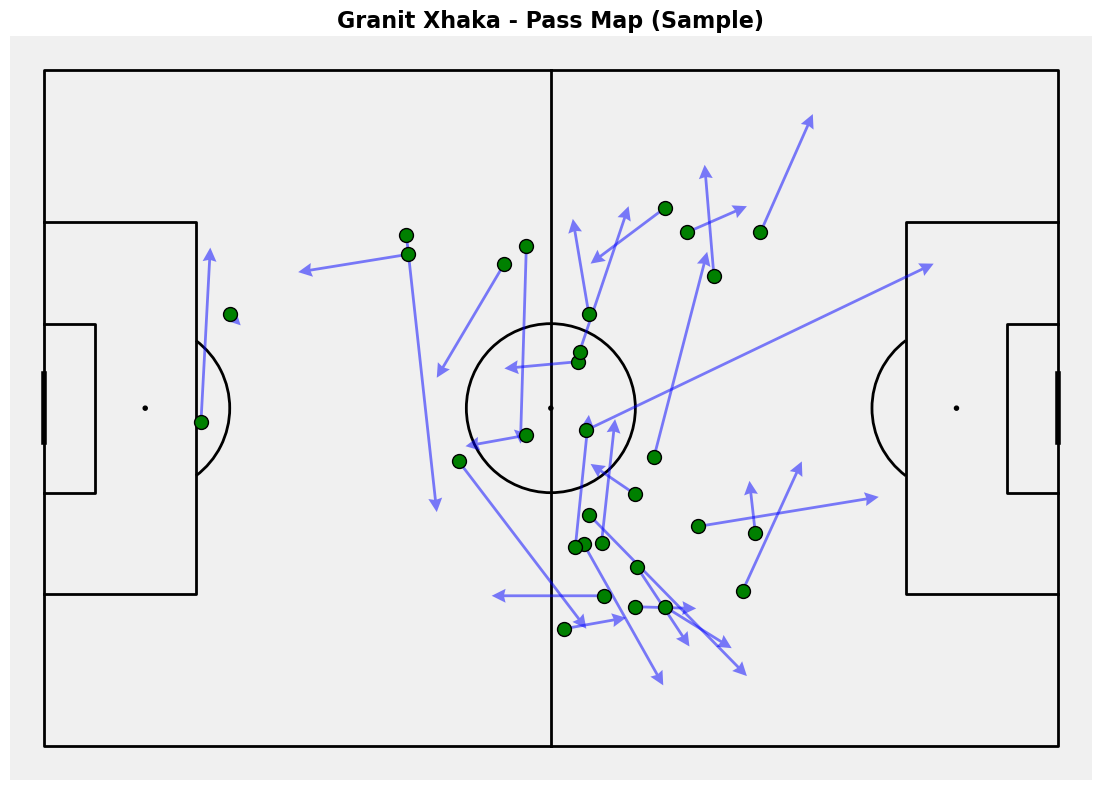

In [13]:
# Visualize pass patterns for Leverkusen players using mplsoccer
if 'valid_passes' in globals() and len(valid_passes) > 0:
    # Extract pass coordinates (StatsBomb uses 120x80 pitch)
    # StatsBomb coordinates need to be converted for mplsoccer (which uses 105x68 by default)
    
    # Filter for a sample player's passes
    sample_player = valid_passes["player"].value_counts().index[0]
    player_passes = valid_passes[valid_passes["player"] == sample_player].head(30).copy()
    
    print(f"Visualizing passes for: {sample_player}")
    print(f"Number of passes: {len(player_passes)}")
    
    # Create pitch using mplsoccer (StatsBomb coordinate system)
    pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='#f0f0f0')
    fig, ax = pitch.draw(figsize=(12, 8))
    
    # Plot passes
    for idx, row in player_passes.iterrows():
        if row.get("location") and row.get("end_location"):
            start = row["location"]
            end = row["end_location"]
            
            # Draw pass line
            pitch.arrows(start[0], start[1], end[0], end[1],
                        ax=ax, color='blue', alpha=0.5, width=2, headwidth=5, headlength=5)
            
            # Mark start location
            pitch.scatter(start[0], start[1], ax=ax, s=100, color='green', 
                         edgecolors='black', zorder=3)
    
    ax.set_title(f'{sample_player} - Pass Map (Sample)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 3.4 Visualize Freeze-Frame with mplsoccer


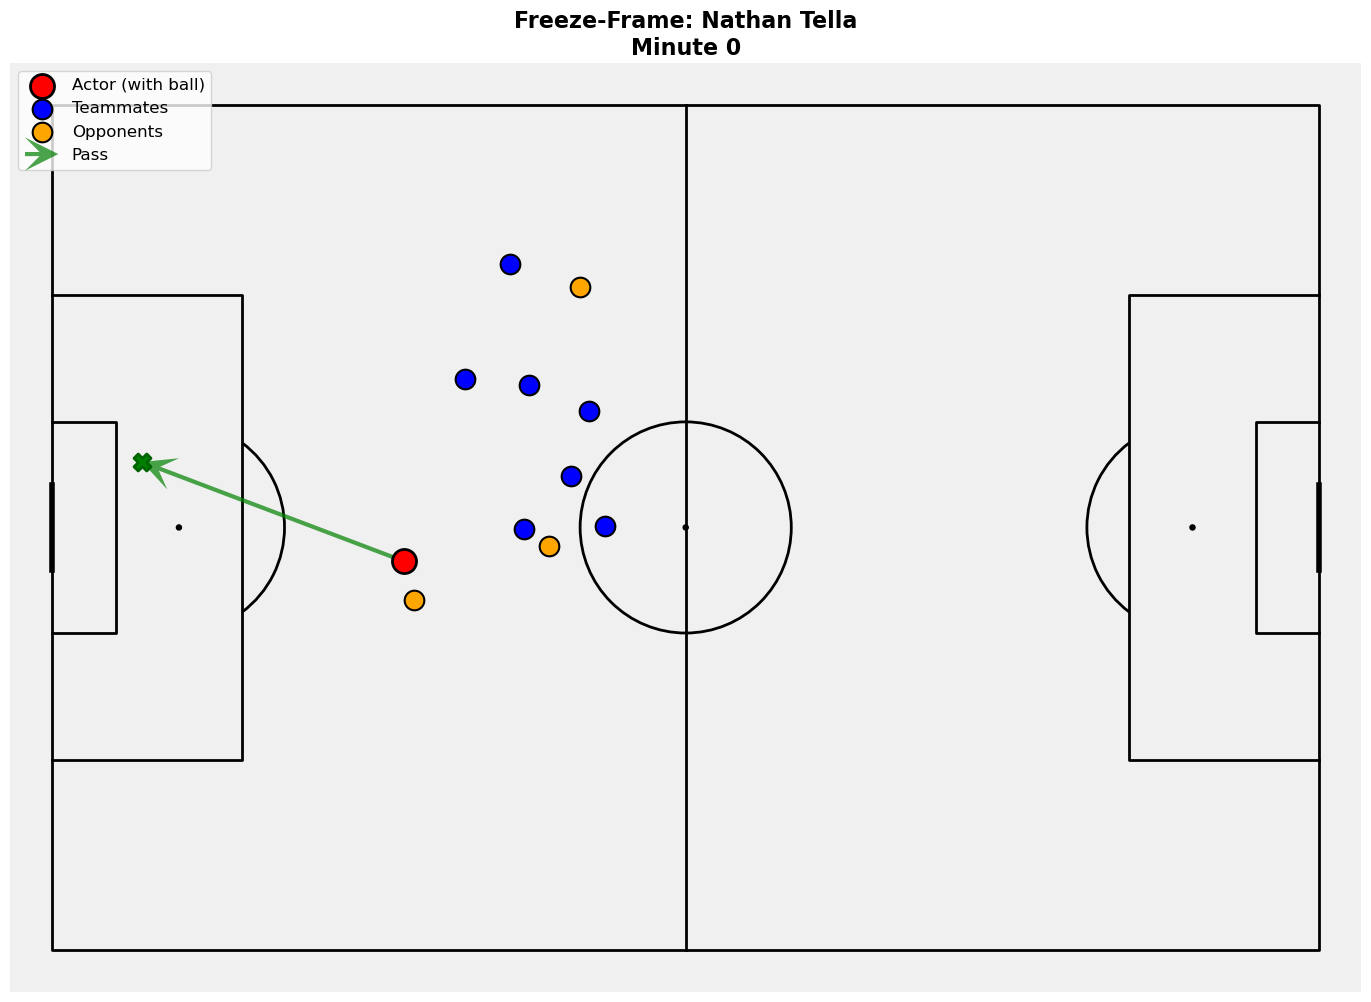

In [14]:
# Visualize a freeze-frame (decision context) with mplsoccer
if 'valid_passes' in globals() and len(valid_passes) > 0:
    sample_event = valid_passes.iloc[0]
    freeze_frame = sample_event.get("freeze_frame", [])
    actor_location = sample_event.get("location")
    end_location = sample_event.get("end_location")
    player_name = sample_event.get("player", "Unknown")
    
    # Create pitch
    pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='#f0f0f0')
    fig, ax = pitch.draw(figsize=(14, 10))
    
    # Plot actor
    if actor_location:
        pitch.scatter(actor_location[0], actor_location[1], ax=ax, 
                     s=300, color='red', edgecolors='black', linewidth=2,
                     zorder=5, label='Actor (with ball)')
    
    # Plot teammates and opponents from freeze-frame
    teammate_locs = []
    opponent_locs = []
    
    for p in freeze_frame:
        loc = p.get("location")
        if not loc:
            continue
        
        if p.get("actor"):
            continue  # Already plotted
        elif p.get("teammate"):
            teammate_locs.append(loc)
        else:
            opponent_locs.append(loc)
    
    # Plot teammates
    if teammate_locs:
        teammate_x = [loc[0] for loc in teammate_locs]
        teammate_y = [loc[1] for loc in teammate_locs]
        pitch.scatter(teammate_x, teammate_y, ax=ax, 
                     s=200, color='blue', edgecolors='black', linewidth=1.5,
                     zorder=4, label='Teammates')
    
    # Plot opponents
    if opponent_locs:
        opponent_x = [loc[0] for loc in opponent_locs]
        opponent_y = [loc[1] for loc in opponent_locs]
        pitch.scatter(opponent_x, opponent_y, ax=ax, 
                     s=200, color='orange', edgecolors='black', linewidth=1.5,
                     zorder=4, label='Opponents')
    
    # Draw pass (if available)
    if actor_location and end_location:
        pitch.arrows(actor_location[0], actor_location[1], 
                    end_location[0], end_location[1],
                    ax=ax, color='green', alpha=0.7, width=3, 
                    headwidth=8, headlength=8, zorder=3, label='Pass')
        # Mark end location
        pitch.scatter(end_location[0], end_location[1], ax=ax, 
                     s=150, color='green', edgecolors='darkgreen', 
                     linewidth=2, marker='X', zorder=5)
    
    ax.set_title(f'Freeze-Frame: {player_name}\nMinute {sample_event.get("minute", "N/A")}', 
                fontsize=16, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()


## 4. Neural Network Model Framework

### Model Architecture Ideas:
1. **Context Encoder**: CNN to process freeze-frame grid (spatial positions of teammates/opponents)
2. **Player Embedding**: Learn player-specific decision patterns
3. **Additional Context Variables**:
   - Pitch zone/region (defensive/middle/attacking)
   - Game state (score, time, match phase)
   - Pressure indicators (number of nearby opponents)
   - Passing options (number of teammates in different zones)
   - Possession context (previous actions in sequence)
   - Tactical formation indicators


### 4.1 Visualize Decision Surfaces on Pitch (mplsoccer)


In [15]:
def plot_decision_surface_mplsoccer(surface, actor_location=None, freeze_frame=None, 
                                     title="Decision Surface", N=12, M=8):
    """
    Visualize decision surface on a professional soccer pitch using mplsoccer.
    Shows where a player is likely to pass given a freeze-frame context.
    """
    # Create pitch
    pitch = Pitch(pitch_type='statsbomb', line_color='white', 
                 pitch_color='#1e3a5f', line_zorder=2)
    fig, ax = pitch.draw(figsize=(14, 10))
    
    # Convert surface from (N, M) grid to full pitch (120, 80)
    # Interpolate to full resolution
    try:
        from scipy.ndimage import zoom
        zoom_factor = (120/surface.shape[0], 80/surface.shape[1])
        surface_full = zoom(surface, zoom_factor, order=1)
    except ImportError:
        # Fallback: simple repeat
        surface_full = np.repeat(np.repeat(surface, 10, axis=0), 10, axis=1)
    
    # Plot heatmap overlay
    im = ax.imshow(surface_full.T, extent=[0, 120, 0, 80], 
                   origin='lower', cmap='Reds', alpha=0.6, 
                   interpolation='bilinear', zorder=1)
    
    # Plot freeze-frame context if available
    if freeze_frame and actor_location:
        teammate_locs = []
        opponent_locs = []
        
        for p in freeze_frame:
            loc = p.get("location")
            if not loc:
                continue
            
            if p.get("actor"):
                continue
            elif p.get("teammate"):
                teammate_locs.append(loc)
            else:
                opponent_locs.append(loc)
        
        # Plot teammates
        if teammate_locs:
            teammate_x = [loc[0] for loc in teammate_locs]
            teammate_y = [loc[1] for loc in teammate_locs]
            pitch.scatter(teammate_x, teammate_y, ax=ax, 
                         s=150, color='blue', edgecolors='white', linewidth=1.5,
                         zorder=4, label='Teammates')
        
        # Plot opponents
        if opponent_locs:
            opponent_x = [loc[0] for loc in opponent_locs]
            opponent_y = [loc[1] for loc in opponent_locs]
            pitch.scatter(opponent_x, opponent_y, ax=ax, 
                         s=150, color='orange', edgecolors='white', linewidth=1.5,
                         zorder=4, label='Opponents')
        
        # Mark actor
        if actor_location:
            pitch.scatter(actor_location[0], actor_location[1], ax=ax, 
                         s=400, color='red', edgecolors='white', linewidth=3,
                         zorder=5, marker='o', label='Actor')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Pass Probability', rotation=270, labelpad=20, color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    
    ax.set_title(title, fontsize=16, fontweight='bold', color='white', pad=20)
    if freeze_frame:
        ax.legend(loc='upper left', fontsize=11, facecolor='#1e3a5f', 
                 edgecolor='white', labelcolor='white')
    
    plt.tight_layout()
    plt.show()


# Example usage (will work once we have a trained model)
print("Decision surface visualization function ready!")
print("Use plot_decision_surface_mplsoccer() to visualize player decision surfaces on pitch")


Decision surface visualization function ready!
Use plot_decision_surface_mplsoccer() to visualize player decision surfaces on pitch


### 4.2 Heatmap Visualization of Pass Patterns


Creating heatmap for: Granit Xhaka
Total passes: 896


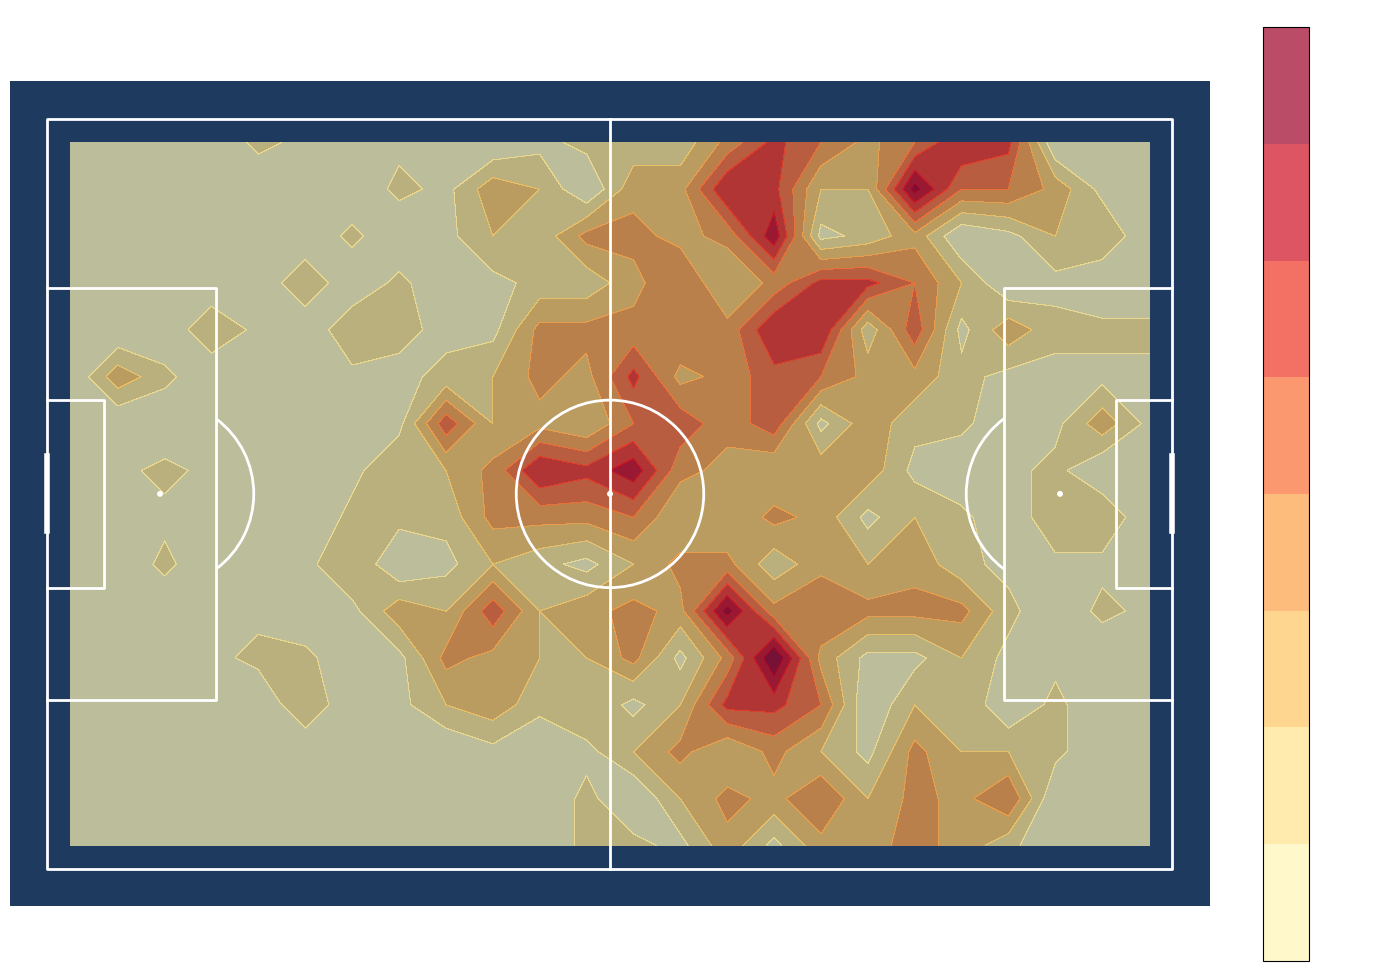

In [16]:
if 'valid_passes' in globals() and len(valid_passes) > 0:
    # Select a player with many passes
    top_player = valid_passes["player"].value_counts().index[0]
    player_passes = valid_passes[valid_passes["player"] == top_player].copy()
    
    print(f"Creating heatmap for: {top_player}")
    print(f"Total passes: {len(player_passes)}")
    
    # Extract end locations for heatmap
    end_locations = []
    for _, row in player_passes.iterrows():
        if row.get("end_location"):
            end_locations.append(row["end_location"])
    
    if end_locations:
        end_x = [loc[0] for loc in end_locations]
        end_y = [loc[1] for loc in end_locations]
        
        # Create pitch and plot
        pitch = Pitch(pitch_type='statsbomb', line_color='white', 
                     pitch_color='#1e3a5f', line_zorder=2)
        fig, ax = pitch.draw(figsize=(14, 10))
        
        # Create 2D histogram for heatmap
        bins = (np.linspace(0, 120, 25), np.linspace(0, 80, 17))
        hist, x_edges, y_edges = np.histogram2d(end_x, end_y, bins=bins)
        
        # Plot heatmap
        extent = [0, 120, 0, 80]
        im = ax.contourf(hist.T, extent=extent, origin='lower', 
                        cmap='YlOrRd', alpha=0.7, levels=10, zorder=1)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Pass Density', rotation=270, labelpad=20, color='white')
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
        
        ax.set_title(f'{top_player}\nPass Destination Heatmap', 
                    fontsize=16, fontweight='bold', color='white', pad=20)
        plt.tight_layout()
        plt.show()


### 4.2 Using EnhancedDecisionNet with DataLoader

Let's use the DataLoader to load data and prepare it for training with EnhancedDecisionNet:


In [17]:
# Load data using DataLoader
loader = DataLoader(base_dir="../data/open-data/data")
loader.process_pipeline(
    team_name="Bayer Leverkusen",
    competition_id=9,
    season_id=281,
    max_matches=3,
    event_types=["Pass"],
    verbose=True
)

data = loader.get_data()
player_id_mapping = loader.get_player_mapping()

print(f"Loaded {len(data)} events")
print(f"Unique players: {len(player_id_mapping)}")

# Initialize model
num_players = len(player_id_mapping) + 1
model = EnhancedDecisionNet(
    num_players=num_players,
    embed_dim=32,
    N=12,
    M=8,
    channels=3,
    context_dim=16,
    hidden_dim=256
)

print(f"\nModel initialized with {num_players} players")


Loading data for Bayer Leverkusen...
Loading Bayer Leverkusen matches...
Matches with 360 data: 34
Processing 3 matches...

 Successfully loaded 3 matches
  Total Bayer Leverkusen events: 6300
  Total expanded freeze-frame data: 85359
✓ Loaded 6300 events from 34 matches
Cleaning data (filtering ['Pass'] events)...
✓ Filtered to 1478 valid events (from 6300 total)
Adding features...
  - Adding pitch zones...
  - Adding context features...
  - Adding player IDs...
✓ Features added successfully
Loaded 1478 events
Unique players: 20

Model initialized with 21 players


In [25]:
# sample batch for testing
# Note: This is a simplified example.
sample_data = data.head(10)

# Get context features and player IDs from the loaded data
if "context_features" in sample_data.columns and "player_id" in sample_data.columns:
    context_features = np.array([row["context_features"] for _, row in sample_data.iterrows()])
    player_ids = sample_data["player_id"].values
    
    # Dummy context grids for testing (in practice, create from freeze-frames)
    batch_size = len(sample_data)
    batch_X = torch.randn(batch_size, 3, 12, 8)  # (batch, channels, N, M)
    batch_context = torch.tensor(context_features).float()
    batch_player_ids = torch.tensor(player_ids).long()
    
    with torch.no_grad():
        probs = model(batch_X, batch_player_ids, batch_context)
    
    print(f"✓ Test forward pass successful!")
    print(f"  Input shapes: X={batch_X.shape}, context={batch_context.shape}, player_ids={batch_player_ids.shape}")
    print(f"  Output shape: {probs.shape}")
    print(f"  Probabilities sum (should be ~{batch_size}): {probs.sum().item():.4f}")
else:
    print("Note: Run DataLoader with add_context_features=True and add_player_ids=True")


✓ Test forward pass successful!
  Input shapes: X=torch.Size([10, 3, 12, 8]), context=torch.Size([10, 16]), player_ids=torch.Size([10])
  Output shape: torch.Size([10, 96])
  Probabilities sum (should be ~10): 10.0000


### 4.3 Model Architecture Visualization


### 4.4 Visualize Model Predictions (Decision Surfaces)


Visualizing model prediction...


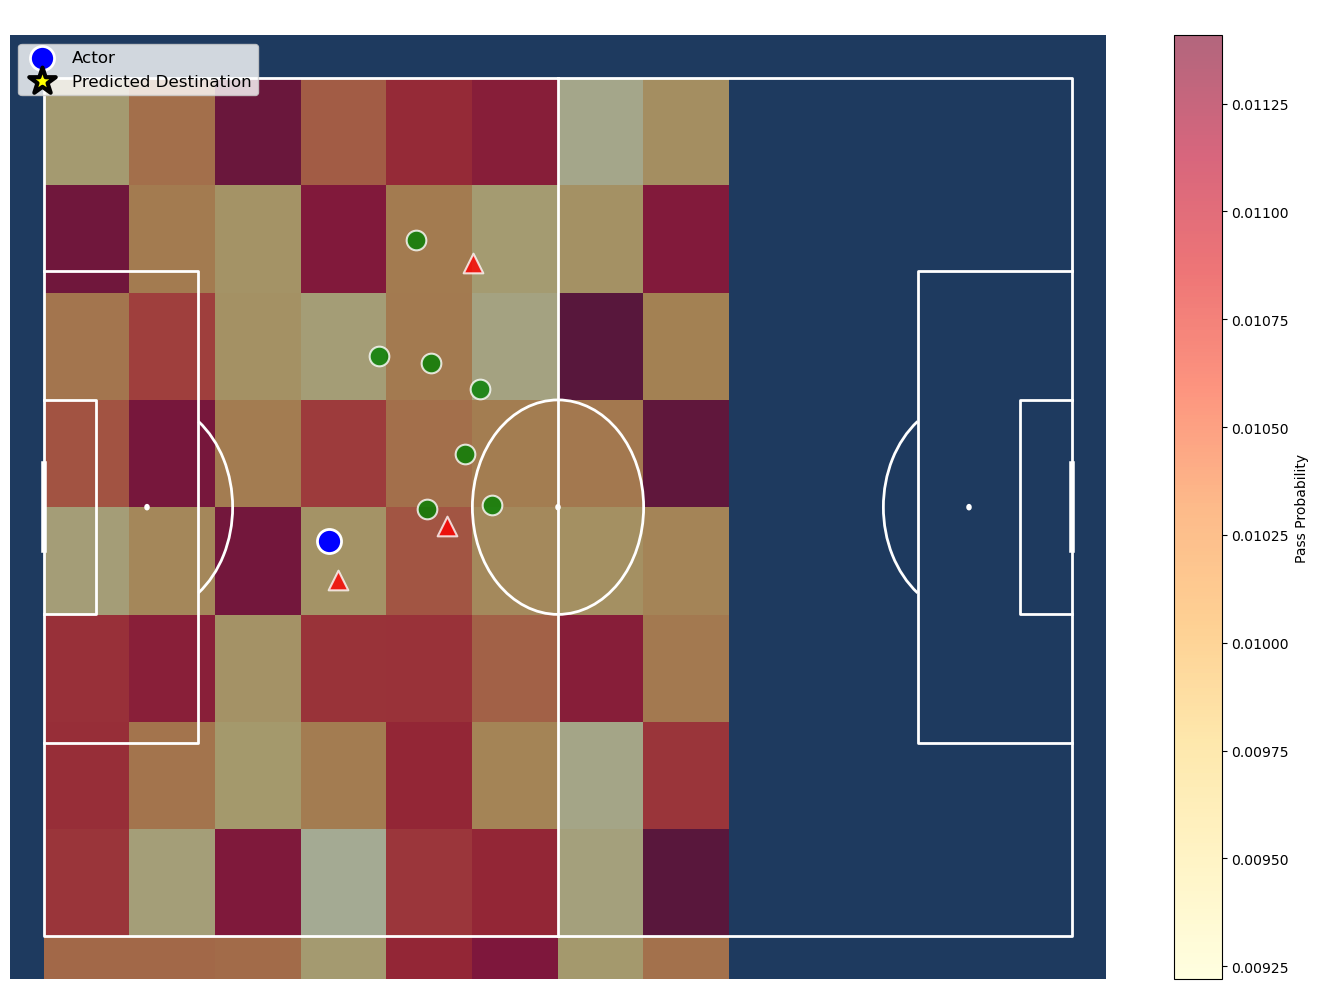


Highest probability cell: Row 1, Col 0
Probability: 0.0114


In [26]:
# Visualize model predictions on the pitch
def visualize_model_prediction(model, context_grid, player_id, context_feat, 
                                actor_location=None, freeze_frame=None, 
                                N=12, M=8, pitch_length=120, pitch_width=80):
    """
    Visualize model's predicted pass destination probabilities on the pitch.
    """
    model.eval()
    
    # Prepare inputs
    X = torch.tensor(context_grid).unsqueeze(0).float()  # (1, 3, N, M)
    pid = torch.tensor([player_id]).long()
    ctx = torch.tensor([context_feat]).float()
    
    # Get predictions
    with torch.no_grad():
        probs = model(X, pid, ctx)
    
    # Reshape probabilities to grid
    prob_grid = probs[0].numpy().reshape(N, M)
    
    # Create visualization
    pitch = Pitch(pitch_type='statsbomb', line_color='white', 
                 pitch_color='#1e3a5f', line_zorder=2)
    fig, ax = pitch.draw(figsize=(14, 10))
    
    # Convert grid coordinates to pitch coordinates for heatmap
    x_cells = np.linspace(0, pitch_width, M+1)
    y_cells = np.linspace(pitch_length, 0, N+1)  # Invert Y axis
    
    # Plot heatmap
    im = ax.imshow(prob_grid, extent=[0, pitch_width, 0, pitch_length], 
                   cmap='YlOrRd', alpha=0.6, aspect='auto', zorder=1)
    plt.colorbar(im, ax=ax, label='Pass Probability')
    
    # Mark actor location
    if actor_location:
        ax.scatter(actor_location[0], actor_location[1], 
                  s=300, color='blue', edgecolors='white', 
                  linewidth=2, marker='o', zorder=5, label='Actor')
    
    # Plot freeze-frame players
    if freeze_frame:
        for player in freeze_frame:
            loc = player.get("location")
            if loc:
                color = 'green' if player.get("teammate") else 'red'
                marker = 'o' if player.get("teammate") else '^'
                ax.scatter(loc[0], loc[1], s=200, color=color, 
                          edgecolors='white', linewidth=1.5, 
                          marker=marker, zorder=4, alpha=0.8)
    
    # Mark highest probability cell
    max_idx = np.unravel_index(np.argmax(prob_grid), prob_grid.shape)
    max_x = (max_idx[1] + 0.5) * (pitch_width / M)
    max_y = pitch_length - (max_idx[0] + 0.5) * (pitch_length / N)
    ax.scatter(max_x, max_y, s=400, color='yellow', 
              edgecolors='black', linewidth=3, marker='*', 
              zorder=6, label='Predicted Destination')
    
    ax.set_title('Model Prediction: Pass Destination Probabilities', 
                fontsize=16, fontweight='bold', color='white')
    ax.legend(loc='upper left', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return prob_grid, max_idx

if len(data) > 0 and "context_features" in data.columns:
    sample_idx = 0
    sample_row = data.iloc[sample_idx]
    
    # Create a dummy context grid for visualization
    # In practice, you'd use create_context_grid() function
    dummy_grid = np.random.rand(3, 12, 8)
    dummy_grid[2, 6, 4] = 1.0  # Actor at center
    
    player_id = sample_row.get("player_id", 0) if "player_id" in sample_row else 0
    context_feat = sample_row["context_features"] if "context_features" in sample_row else np.zeros(16)
    actor_loc = sample_row.get("location")
    freeze_frame = sample_row.get("freeze_frame")
    
    print("Visualizing model prediction...")
    prob_grid, max_idx = visualize_model_prediction(
        model, dummy_grid, player_id, context_feat,
        actor_location=actor_loc,
        freeze_frame=freeze_frame
    )
    
    print(f"\nHighest probability cell: Row {max_idx[0]}, Col {max_idx[1]}")
    print(f"Probability: {prob_grid[max_idx]:.4f}")
else:
    print("Load data first to visualize predictions")


Visualizing player embeddings...
Player Embedding Statistics:
  Embedding shape: (21, 32)
  Mean norm: 5.7622
  Std norm: 0.7781


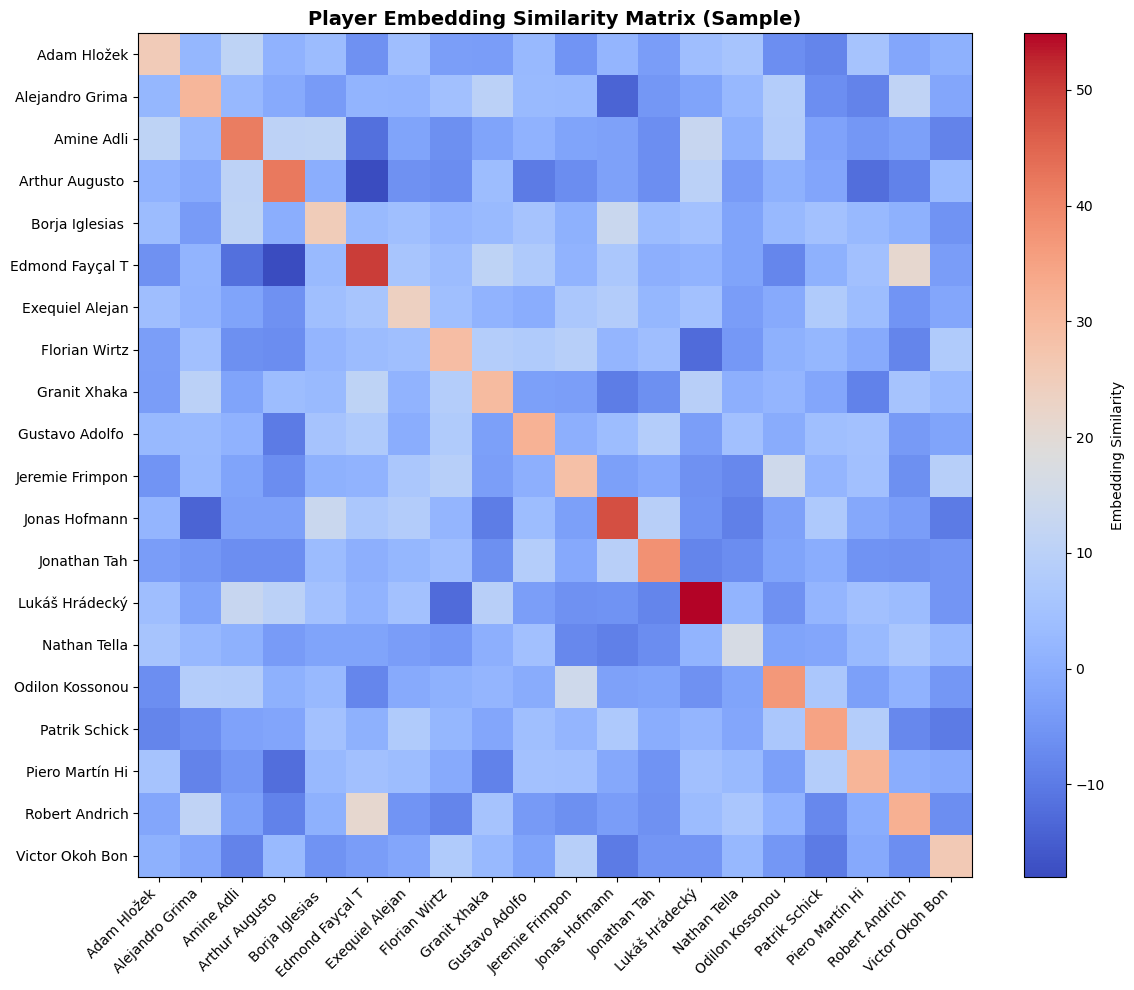

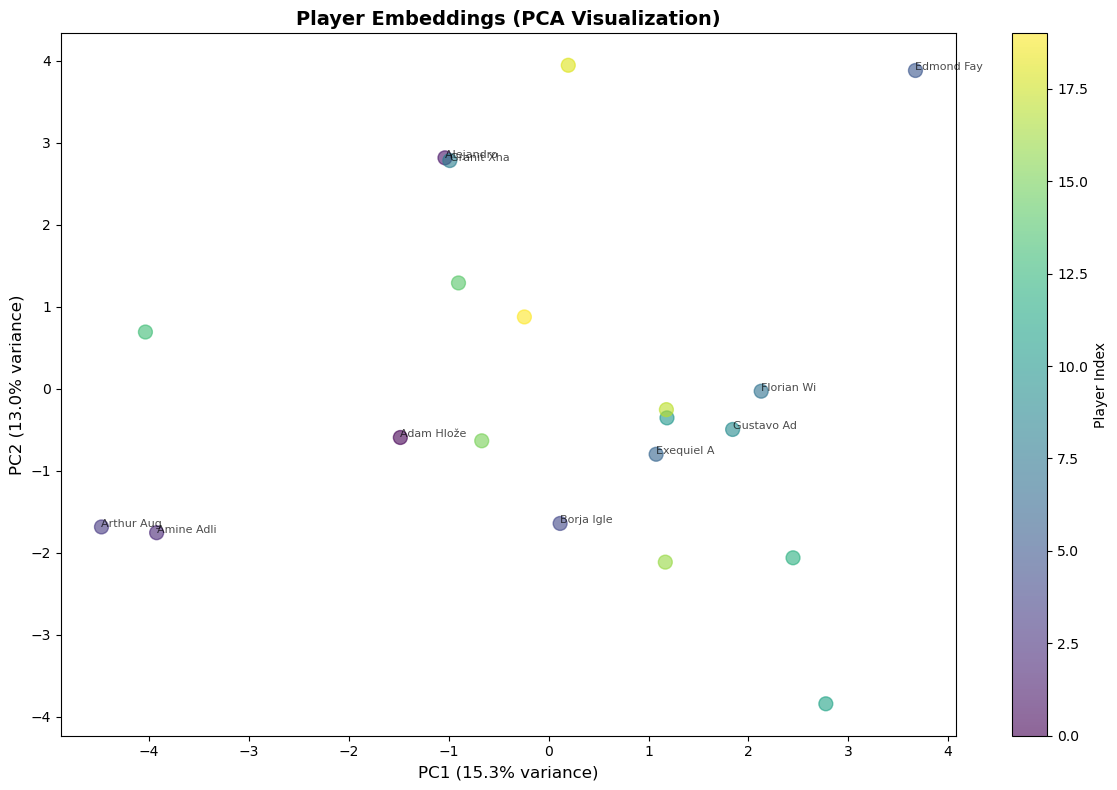


✓ PCA visualization: 28.3% variance explained


In [ ]:
# Visualize player embeddings (if model has been trained)
# This shows how similar different players are based on their embeddings

def visualize_player_embeddings(model, player_id_mapping, top_n=20):
    """
    Visualize player embeddings using PCA/t-SNE if available,
    or show embedding norms and statistics.
    """
    # Extract embedding weights
    embedding_layer = model.player_embed
    embeddings = embedding_layer.weight.data.numpy()  # (num_players, embed_dim)
    
    print(f"Player Embedding Statistics:")
    print(f"  Embedding shape: {embeddings.shape}")
    print(f"  Mean norm: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
    print(f"  Std norm: {np.linalg.norm(embeddings, axis=1).std():.4f}")
    
    # Compute pairwise similarities for a sample of players
    sample_size = min(top_n, len(player_id_mapping))
    sample_indices = list(range(sample_size))
    
    sample_embeddings = embeddings[sample_indices]
    similarities = np.dot(sample_embeddings, sample_embeddings.T)
    
    # Visualize similarity matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(similarities, cmap='coolwarm', aspect='auto')
    
    # Get player names (first few from mapping)
    player_names = list(player_id_mapping.keys())[:sample_size]
    ax.set_xticks(range(sample_size))
    ax.set_yticks(range(sample_size))
    ax.set_xticklabels([name[:15] for name in player_names], rotation=45, ha='right')
    ax.set_yticklabels([name[:15] for name in player_names])
    
    plt.colorbar(im, ax=ax, label='Embedding Similarity')
    ax.set_title('Player Embedding Similarity Matrix (Sample)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    try:
        from sklearn.decomposition import PCA
        from sklearn.manifold import TSNE
        
        # PCA
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings[:sample_size])
        
        fig, ax = plt.subplots(figsize=(12, 8))
        scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                           s=100, alpha=0.6, c=range(sample_size), cmap='viridis')
        
        # Annotate top players
        for i, name in enumerate(player_names[:min(10, sample_size)]):
            ax.annotate(name[:10], (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                       fontsize=8, alpha=0.7)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
        ax.set_title('Player Embeddings (PCA Visualization)', fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Player Index')
        plt.tight_layout()
        plt.show()
        
        print(f"\nPCA visualization: {pca.explained_variance_ratio_.sum():.1%} variance explained")
    except ImportError:
        print("\n(Install sklearn for PCA visualization: pip install scikit-learn)")
    
    return embeddings

# Visualize embeddings
if len(player_id_mapping) > 0:
    print("Visualizing player embeddings...")
    embeddings = visualize_player_embeddings(model, player_id_mapping, top_n=20)
else:
    print("Load data with player mappings first")


In [95]:
# Visualize decision surfaces for player comparison
def compare_player_decisions(model, grid, player_ids, player_names, N=12, M=8):
    """
    Compare decision surfaces for different players in the same situation.
    This is the key for player similarity analysis.
    """
    model.eval()
    surfaces = {}
    
    with torch.no_grad():
        x = torch.tensor(grid).unsqueeze(0).permute(0, 3, 1, 2).float()
        
        for pid, pname in zip(player_ids, player_names):
            pid_tensor = torch.tensor([pid])
            # Note: context_features would need to be provided in real scenario
            dummy_context = torch.zeros(1, 16)
            probs = model(x, pid_tensor, dummy_context).squeeze(0).cpu().numpy()
            surfaces[pname] = probs.reshape(N, M)
    
    return surfaces


def plot_surface_comparison(surfaces, title="Decision Surface Comparison", pitch_length=120, pitch_width=80):
    """Plot decision surfaces side-by-side"""
    n_players = len(surfaces)
    fig, axes = plt.subplots(1, n_players, figsize=(5*n_players, 7))
    
    if n_players == 1:
        axes = [axes]
    
    for idx, (pname, surface) in enumerate(surfaces.items()):
        ax = axes[idx]
        ax.set_xlim(0, pitch_length)
        ax.set_ylim(0, pitch_width)
        ax.set_aspect('equal')
        
        extent = [0, pitch_length, 0, pitch_width]
        im = ax.imshow(surface.T, origin='lower', extent=extent,
                      cmap="Reds", alpha=0.7, aspect="auto")
        ax.set_title(f"{pname}")
        ax.invert_yaxis()  # Match soccer convention
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## 6. Comprehensive Next Steps & Roadmap

### Phase 1: Data Collection & Preparation (Week 1-2)

#### 6.1 Complete Data Loading
- [ ] Load ALL Leverkusen matches from 2023/24 season (34 matches)
- [ ] Verify 360 data availability for each match
- [ ] Handle missing/partial freeze-frame data gracefully
- [ ] Create unified dataset with all pass events + freeze-frames

#### 6.2 Data Cleaning & Validation
- [ ] Filter invalid events (missing locations, empty freeze-frames)
- [ ] Handle edge cases (penalty box situations, set pieces)
- [ ] Validate data consistency across matches
- [ ] Create data quality reports (passes per player, coverage per match)

#### 6.3 Feature Engineering
- [ ] Extract context features for all events:
  - [ ] Pitch zone encoding (defensive/middle/attacking)
  - [ ] Pressure metrics (opponents within X meters)
  - [ ] Passing options (teammates in different zones)
  - [ ] Game state (score, time, match phase)
  - [ ] Tactical context (formation, team shape)
- [ ] Create player-to-ID mapping for embedding layer
- [ ] Build temporal features (previous actions in possession)

### Phase 2: Model Development (Week 3-4)

#### 6.4 Dataset Preparation
- [ ] Split data: train/validation/test (80/10/10)
- [ ] Ensure balanced representation across:
  - [ ] Players (min events per player threshold)
  - [ ] Match contexts (home/away, different opponents)
  - [ ] Pitch zones (defensive/middle/attacking)
- [ ] Create data loaders with proper batching

#### 6.5 Model Implementation
- [ ] Implement `EnhancedDecisionNet` architecture
- [ ] Add optional components:
  - [ ] LSTM/Transformer for temporal sequences
  - [ ] Attention mechanisms for key players/spaces
  - [ ] Multi-task learning (pass destination + success prediction)
- [ ] Implement training loop with:
  - [ ] Learning rate scheduling
  - [ ] Early stopping
  - [ ] Model checkpointing

#### 6.6 Model Training
- [ ] Train initial model on full Leverkusen dataset
- [ ] Hyperparameter tuning:
  - [ ] Embedding dimensions (16, 32, 64)
  - [ ] CNN architecture (depth, channels)
  - [ ] Learning rates
  - [ ] Dropout rates
- [ ] Track training metrics (loss, accuracy, top-k accuracy)

### Phase 3: Validation & Embedding Analysis (Week 5)

#### 6.7 Model Validation
- [ ] Cross-validation: train on N-1 matches, validate on 1 match
- [ ] Check embedding stability: same player → similar embedding across matches
- [ ] Evaluate predictive accuracy:
  - [ ] Top-1 accuracy (exact cell prediction)
  - [ ] Top-5 accuracy (within 5 cells)
  - [ ] Distance-based accuracy (within X meters)

#### 6.8 Player Embedding Extraction
- [ ] Extract embeddings for all Leverkusen players
- [ ] Analyze embedding space:
  - [ ] PCA/t-SNE visualization of player embeddings
  - [ ] Cluster analysis (which players group together?)
  - [ ] Embedding dimensions analysis (what do dimensions encode?)

#### 6.9 Decision Surface Analysis
- [ ] Generate decision surfaces for key players in common situations
- [ ] Compare surfaces using:
  - [ ] KL divergence between probability distributions
  - [ ] Mean squared difference
  - [ ] Context-specific similarity (similar in specific zones/situations)
- [ ] Visualize differences with mplsoccer

### Phase 4: Similarity Analysis (Week 6)

#### 6.10 Similarity Metrics Implementation
- [ ] Cosine similarity in embedding space
- [ ] Decision surface similarity (as in Central Winger article)
- [ ] Context-aware similarity:
  - [ ] Similar in defensive situations
  - [ ] Similar in high-pressure scenarios
  - [ ] Similar in final third
- [ ] Position-aware similarity (account for tactical roles)

#### 6.11 Player Similarity Network
- [ ] Build similarity matrix (all players vs all players)
- [ ] Create network graph (players as nodes, similarity as edges)
- [ ] Identify player clusters/groups
- [ ] Find most/least similar player pairs
- [ ] Analyze what makes players similar (context patterns)

#### 6.12 Interpretability Analysis
- [ ] Analyze what contexts trigger different decisions
- [ ] Compare player decision-making in:
  - [ ] Different pitch zones
  - [ ] Different game states (leading/trailing)
  - [ ] Different pressure situations
- [ ] Create player "decision profiles"

### Phase 5: Research & Model Enhancement (Week 7-8)

#### 6.13 Research Papers to Review

**Player Embeddings & Similarity:**
- [ ] "Substituting Similarity" (Central Winger) - already referenced
- [ ] "Player Vectors: Characterizing Soccer Players' Playing Style from Match Event Data" (StatsBomb)
- [ ] "Representation Learning for Player Identification" papers
- [ ] Graph Neural Networks for player similarity (e.g., "Graph Attention Networks")

**Decision-Making & Action Prediction:**
- [ ] "Actions Speak Louder than Goals" - action value models
- [ ] "The Expected Value of Possession" papers
- [ ] "Passing Networks" and team dynamics papers
- [ ] "Machine Learning for Soccer Analytics" survey papers

**Temporal & Sequence Modeling:**
- [ ] LSTM/GRU for action sequences
- [ ] Transformer architectures for soccer (if available)
- [ ] "Possession chains" and build-up play analysis

**Spatial Analysis:**
- [ ] Graph Neural Networks for spatial soccer data
- [ ] "Spatial analysis of passing networks" papers
- [ ] Formation detection from tracking data

#### 6.14 Model Enhancements to Implement

**Temporal Context:**
- [ ] Add LSTM layer for previous actions in possession
- [ ] Model possession chains (sequences of passes)
- [ ] Capture momentum/rhythm in play

**Advanced Spatial Features:**
- [ ] Graph Neural Network on freeze-frame (players as nodes)
- [ ] Attention to specific teammates (learn which teammates matter)
- [ ] Space-based features (Voronoi diagrams, space control)
- [ ] Opposition shape analysis (defensive line height, width)

**Multi-Task Learning:**
- [ ] Predict pass destination (current task)
- [ ] Predict pass success probability
- [ ] Predict pass type (ground/aerial, short/long, forward/lateral/backward)
- [ ] Predict next action type (pass/carry/shot)

**Context-Aware Embeddings:**
- [ ] Separate embeddings for different contexts
- [ ] Or single embedding with context conditioning
- [ ] Compare both approaches

### Phase 6: Visualization & Reporting (Week 9)

#### 6.15 Advanced Visualizations
- [ ] Interactive player similarity dashboard
- [ ] Decision surface comparisons for similar players
- [ ] Embedding space visualization (t-SNE/PCA with player labels)
- [ ] Pass pattern heatmaps by player
- [ ] Context-specific decision maps

#### 6.16 Case Studies
- [ ] Deep dive: Compare 2-3 similar players
  - [ ] When do they make different decisions?
  - [ ] What contexts make them similar/different?
- [ ] Player substitution analysis:
  - [ ] Who are the most similar substitutes?
  - [ ] How do decisions change when player replaced?

#### 6.17 Documentation & Presentation
- [ ] Document methodology and findings
- [ ] Create visual reports for stakeholders
- [ ] Compare with expert knowledge:
  - [ ] Do similar players match expert opinion?
  - [ ] What new insights does the model reveal?
- [ ] Prepare presentation materials

### Phase 7: Extension & Future Work (Week 10+)

#### 6.18 Additional Analyses
- [ ] Expand beyond Leverkusen: compare to other teams
- [ ] Temporal analysis: how do player embeddings change over season?
- [ ] Tactical analysis: how do embeddings reflect Xabi Alonso's system?
- [ ] Opponent-specific analysis: similar decisions vs different opponents?

#### 6.19 Model Improvements
- [ ] Incorporate physical attributes (if available)
- [ ] Add match importance context
- [ ] Model player fatigue/injury effects
- [ ] Account for opponent quality/strength

#### 6.20 Production Considerations
- [ ] Model serving infrastructure
- [ ] Real-time embedding computation
- [ ] Integration with existing analytics pipelines
- [ ] API for similarity queries

### Key Research Questions to Answer:
1. **Are player embeddings stable across matches?** (Validation question)
2. **Do similar players have similar decision-making patterns?** (Core hypothesis)
3. **How does context affect similarity?** (Context-aware analysis)
4. **Can we find unexpected player similarities?** (Discovery)
5. **Do embeddings capture tactical roles?** (Interpretability)

### Success Metrics:
- ✅ Model accuracy: >40% top-1, >70% top-5 for pass destination prediction
- ✅ Embedding stability: Same player embeddings correlate >0.7 across matches
- ✅ Similarity validation: Expert-identified similar players show high cosine similarity
- ✅ Novel insights: Discover at least 3 non-obvious player similarities


### 6.21 Immediate Action Items (Priority Order)

**Week 1: Get Data Pipeline Working**
1. ✅ Fix data loading (DONE - matches are loading)
2. ⏳ Load all 34 Leverkusen matches with 360 data
3. ⏳ Create comprehensive dataset builder function
4. ⏳ Validate data quality and coverage

**Week 2: Build Training Pipeline**
1. ⏳ Implement dataset class for PyTorch
2. ⏳ Create train/val/test splits
3. ⏳ Implement training loop
4. ⏳ Train initial baseline model

**Week 3-4: Model Refinement**
1. ⏳ Experiment with different architectures
2. ⏳ Hyperparameter tuning
3. ⏳ Add temporal/sequence features
4. ⏳ Multi-task learning experiments

**Week 5: Analysis & Validation**
1. ⏳ Extract player embeddings
2. ⏳ Compute similarity matrices
3. ⏳ Generate decision surfaces
4. ⏳ Validate with cross-match testing

**Week 6+: Deep Analysis & Paper Reading**
1. ⏳ Read relevant papers (see list above)
2. ⏳ Implement advanced features from literature
3. ⏳ Case studies on specific players
4. ⏳ Document findings and insights


### 6.22 Research Papers & Resources

**Essential Reading:**
1. **Central Winger - Substituting Similarity**
   - URL: https://www.centralwinger.com/p/substituting-similarity
   - Key concepts: Player embeddings, decision surfaces, substitution bias

2. **StatsBomb Research Papers**
   - Check StatsBomb research section for player analysis papers
   - Action value models and expected goals frameworks

3. **Soccer Analytics Literature**
   - Search: "player embeddings soccer football"
   - Search: "decision making soccer analytics"
   - Search: "graph neural networks sports"

**Academic Databases to Search:**
- arXiv (cs, stat sections)
- Google Scholar
- ResearchGate
- Conference proceedings: MIT Sloan Sports Analytics, NESSIS

**Keywords for Paper Search:**
- "player similarity", "player embeddings", "action prediction"
- "spatial analysis soccer", "freeze-frame analysis"
- "graph neural networks sports", "temporal action prediction"
- "context-aware embeddings", "multi-task learning sports"


In [ ]:
# Helper function to build complete dataset for model training
def build_complete_dataset(leverkusen_matches, matches_with_360, base_dir="../data/open-data/data", 
                          event_types=["Pass"], max_matches=None):
    """
    Build comprehensive dataset from all Leverkusen matches.
    Returns: X (grids), y (labels), player_ids, context_features, metadata
    """
    all_samples = []
    
    matches_to_load = leverkusen_matches[:max_matches] if max_matches else leverkusen_matches
    
    print(f"Building dataset from {len(matches_to_load)} matches...")
    
    for match_idx, match in enumerate(matches_to_load):
        match_id = match["match_id"]
        
        if match_id not in matches_with_360:
            continue
            
        try:
            match_id_str = str(match_id)
            event_df, expanded_df, lineup_lookup = load_full_match(match_id_str, base_dir=base_dir)
            
            # Filter for Leverkusen events
            leverkusen_events = event_df[
                event_df["team"].str.contains("Leverkusen", case=False, na=False)
            ].copy()
            
            # Filter for specified event types
            leverkusen_events = leverkusen_events[
                leverkusen_events["type"].isin(event_types)
            ].copy()
            
            # Process each event
            for _, event in leverkusen_events.iterrows():
                # Skip if missing required data
                if (event.get("location") is None or 
                    event.get("end_location") is None or
                    len(event.get("freeze_frame", [])) == 0):
                    continue
                
                # Build grid
                grid = freeze_frame_to_grid(
                    event["freeze_frame"], 
                    event["location"],
                    N=12, M=8
                )
                
                # Get label
                i, j, label = location_to_label(event["end_location"], N=12, M=8)
                if label is None:
                    continue
                
                # Get player ID (need to map player name to ID)
                player_name = event.get("player")
                player_id = None  # TODO: map player name to unique ID
                
                # Extract context features
                context = extract_context_features(event)
                
                all_samples.append({
                    "grid": grid,
                    "label": label,
                    "player_id": player_id,
                    "player_name": player_name,
                    "context": context,
                    "match_id": match_id,
                    "event_id": event.get("event_id"),
                    "location": event.get("location"),
                    "end_location": event.get("end_location"),
                    "minute": event.get("minute"),
                })
                
        except Exception as e:
            print(f"Error processing match {match_id}: {e}")
            continue
        
        if (match_idx + 1) % 5 == 0:
            print(f"  Processed {match_idx + 1}/{len(matches_to_load)} matches, "
                  f"{len(all_samples)} samples so far...")
    
    print(f"\nDataset complete: {len(all_samples)} samples from {len(matches_to_load)} matches")
    return all_samples


# Note: This function can be called once data loading is working
# Example: dataset = build_complete_dataset(leverkusen_matches, matches_with_360, max_matches=10)
print("Dataset builder function ready!")
print("Call build_complete_dataset() to create training data once matches are loading correctly.")


Dataset builder function ready!
Call build_complete_dataset() to create training data once matches are loading correctly.


### 6.23 Code Structure Recommendations

**Suggested file organization:**
```
Player-decision-simulation/
├── code/
│   ├── data_load.py          # ✅ Existing - data loading
│   ├── dataset.py            # ⏳ NEW - PyTorch Dataset class
│   ├── models.py             # ⏳ NEW - Neural network architectures
│   ├── training.py           # ⏳ NEW - Training loops, utilities
│   ├── similarity.py         # ⏳ NEW - Similarity metrics & analysis
│   └── visualization.py      # ⏳ NEW - Advanced visualizations
├── notebooks/
│   ├── eda.ipynb            # ✅ Current - EDA and exploration
│   ├── training.ipynb       # ⏳ NEW - Model training
│   ├── similarity.ipynb     # ⏳ NEW - Similarity analysis
│   └── results.ipynb         # ⏳ NEW - Results and visualizations
└── data/
    └── open-data/            # ✅ Existing - StatsBomb data
```

**Next notebook to create: `training.ipynb`**
- Dataset preparation
- Model training
- Hyperparameter tuning
- Evaluation metrics


In [91]:
# Summary statistics
if 'valid_passes' in globals() and len(valid_passes) > 0:
    print("=== Dataset Summary ===")
    print(f"Total valid pass events: {len(valid_passes)}")
    print(f"\nEvent distribution by player:")
    top_players = valid_passes["player"].value_counts().head(10)
    print(top_players)
    
    if "start_zone" in valid_passes.columns:
        print(f"\nPitch zones:")
        print(valid_passes["start_zone"].value_counts())
    
    print(f"\nReady for model training!")
    print(f"\nKey insights:")
    print(f"- We can build player embeddings from {len(valid_passes)} pass decisions")
    print(f"- Each decision includes spatial context (freeze-frame) and outcome (end_location)")
    print(f"- This enables comparison of decision-making tendencies across Leverkusen players")
else:
    print("valid_passes not available. Please run cells 9 and 11 first to load and process the data.")


=== Dataset Summary ===
Total valid pass events: 6213

Event distribution by player:
player
Granit Xhaka                   896
Jonathan Tah                   693
Robert Andrich                 611
Edmond Fayçal Tapsoba          527
Florian Wirtz                  455
Piero Martín Hincapié Reyna    437
Alejandro Grimaldo García      429
Exequiel Alejandro Palacios    363
Odilon Kossonou                354
Josip Stanišić                 270
Name: count, dtype: int64

Pitch zones:
start_zone
middle       3377
attacking    1924
defensive     912
Name: count, dtype: int64

Ready for model training!

Key insights:
- We can build player embeddings from 6213 pass decisions
- Each decision includes spatial context (freeze-frame) and outcome (end_location)
- This enables comparison of decision-making tendencies across Leverkusen players
